# Similarity and Transformers
A big part of NLP relies on measuring similarity in highly-dimensional spaces. Many NLP solutions take some text, process it to create a big vector/array representing said text - then perform several transformations.

In this section we'll cover measuring sentence similarity - a great example of how powerful simple similarity metrics can be when paired with transformers.

The logic in producing a solution like this can be split into two steps:

- Take sentences, convert them into vectors (using a transformer).

- Use a similarity metric (more on this later) to find the closest matching sentences.

# Dense Vectors
BERT and many other transformer models are able to take text, and encode a significant amount of information into vectors which represent that text. This means that semantically similar sentences, will be represented by similar vectors.

We call these vectors dense because every value within the vector has a value and has a reason for being that value - this is in contrast to sparse vectors, such as one-hot encoded vectors where the majority of values are 0. BERT is great at creating these dense vectors, and each encoder layer (there are several) outputs a set of dense vectors.

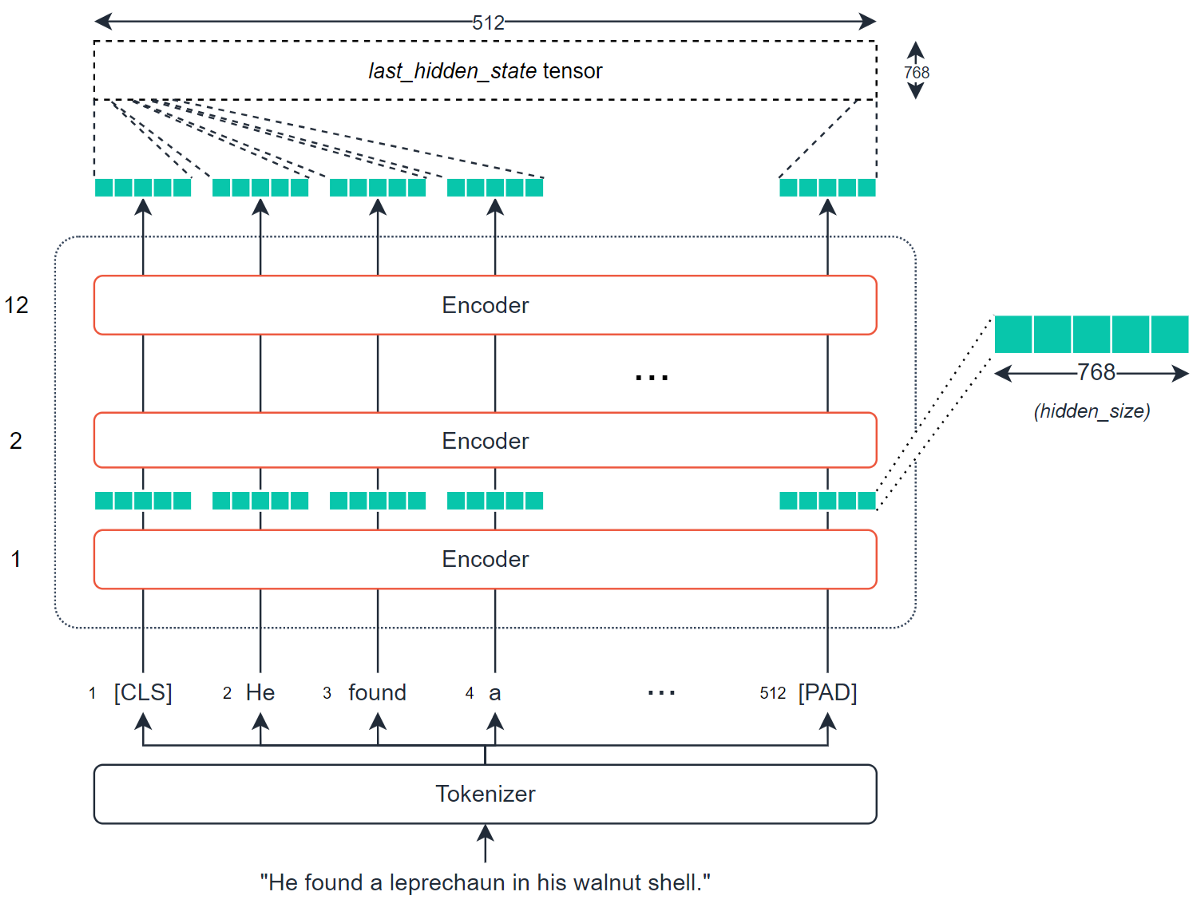

For BERT base, this will be a vector containing 768. Those 768 values contain our numerical representation of a single token - which we can use as contextual word embeddings.

Because there is one of these vectors for representing each token (output by each encoder), we are actually looking at a tensor of size 768 by the number of tokens. We can take these tensors - and transform them to create semantic representations of the input sequence. We can then take our similarity metrics and calculate the respective similarity between different sequences.

The simplest and most commonly extracted tensor is the last_hidden_state tensor - which is conveniently output by the BERT model. Of course, this is a pretty large tensor - at 512x768 - and we want a vector to apply our similarity measures to it. To do this, we need to convert our last_hidden_states tensor to a vector of 768 dimensions.

This compressed vector is our **sentence embedding** (or sentence vector) - it is this that we then take and compare to other sentence embeddings using a similarity metric (like cosine similarity - again, more on this later).

After that, we're done!

# Building Dense Vectors using Transformers

In [1]:
from transformers import AutoModel, AutoTokenizer
import torch

In [3]:
# model initialization 
# The model name is being pu
model_name = 'sentence-transformers/stsb-distilbert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedder = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [4]:
sample_text = 'Bollywood is one of the biggest film making industry.'

tokens = tokenizer.encode_plus(
    text = sample_text,
    max_length = 128, # This model has max token size as 128 rather 512
    truncation = True,
    padding = 'max_length',
    return_tensors = 'pt'
)

In [7]:
tokens['input_ids']

tensor([[  101, 16046,  2003,  2028,  1997,  1996,  5221,  2143,  2437,  3068,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [6]:
tokens['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [8]:
model_ouput = embedder(**tokens)
# extract the last hidden state of the model output
embeddings = model_ouput.last_hidden_state
embeddings

tensor([[[ 0.6514,  0.0578, -0.0492,  ..., -0.2427,  0.5832,  0.5160],
         [ 1.2403,  0.0414, -0.2138,  ..., -0.2354,  0.6999,  0.1671],
         [ 0.4999, -0.1253, -0.2358,  ..., -0.2421,  0.7655,  0.4221],
         ...,
         [ 0.4773, -0.3649,  0.1173,  ...,  0.0264,  0.4653,  0.3998],
         [ 0.4868, -0.3546, -0.0301,  ..., -0.0157,  0.5462,  0.4521],
         [ 0.7752, -0.2784, -0.1201,  ..., -0.0229,  0.6515,  0.4428]]],
       grad_fn=<NativeLayerNormBackward0>)

In [9]:
embeddings.shape

torch.Size([1, 128, 768])

The shape of embeddings as as follows:
- **1** means the sentence that was input to model
- **128** means the total number token or max_length that was given
- **768** means each token (~word) is converted into an embedding vector of length 768

Now for extracting only the embeddings that are related to the words in the input string, a mean pooling operation is to be performed by multiplying the embeddings with the attention_mask array. This will remove all masked imbedding and only keep the relevant word related embedding. 

In [10]:
attention_mask = tokens['attention_mask']
attention_mask.shape

torch.Size([1, 128])

In [11]:
# need to extend the attention_mask to match with embedding shape
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([1, 128, 768])

In [13]:
# This means each input in mask represents a token with length 768 with value 1 for relevant tokens and 
# 0 for padding tokens 
mask[0][0].shape

torch.Size([768])

In [14]:
masked_embedding = embeddings * mask

In [15]:
masked_embedding

tensor([[[ 0.6514,  0.0578, -0.0492,  ..., -0.2427,  0.5832,  0.5160],
         [ 1.2403,  0.0414, -0.2138,  ..., -0.2354,  0.6999,  0.1671],
         [ 0.4999, -0.1253, -0.2358,  ..., -0.2421,  0.7655,  0.4221],
         ...,
         [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000,  0.0000]]],
       grad_fn=<MulBackward0>)

In [20]:
masked_embedding[0].shape

torch.Size([128, 768])

Imagine this as a dataframe with 128 rows(word tokens + masked tokens) and 768 columns that represent the length of each token embedding

We are now summing the all rows along 768 columns. As a result we get a single row with 768 columns

In [26]:
summed = torch.sum(masked_embedding, 1)
print(summed.shape)

torch.Size([1, 768])


In [27]:
summed_mask = torch.clamp(mask.sum(1), min= 1e-9)
summed_mask.shape

torch.Size([1, 768])

In [43]:
summed_mask.sum(1)

tensor([9216.])

In [30]:
mean_pooled = summed / summed_mask


In [32]:
mean_pooled.shape

torch.Size([1, 768])

In [34]:
summed

tensor([[ 9.3976e+00,  6.5725e-01, -1.0687e+00, -7.2744e-01,  7.8285e+00,
          1.1379e+01,  7.3453e+00, -7.6363e+00,  7.9156e-01, -9.0279e+00,
          7.1865e+00,  1.5930e+00,  1.1376e+01,  2.0157e+00,  2.6931e+00,
         -2.3034e+01, -3.8033e+00,  7.8004e-01,  3.7073e-01, -3.8920e+00,
          7.9943e-01,  9.0245e-01,  7.2438e+00,  6.4547e+00, -5.1978e+00,
         -6.6820e+00, -6.0732e+00, -2.5925e+00, -4.8429e+00, -4.6836e+00,
          6.5222e+00, -1.3583e+00, -3.7391e+00,  1.5530e+01,  1.2842e+00,
         -1.6875e+00, -2.0463e-01,  6.4203e+00,  1.4341e+01, -6.5504e+00,
          3.0221e+00, -1.9972e+00,  9.7152e+00,  2.7384e+00, -1.9839e+01,
         -1.4875e+00,  5.7773e+00,  5.7322e+00, -1.0557e+00,  5.0511e+00,
         -2.9981e+00,  1.2259e+01, -6.3222e+00, -6.8243e-02, -4.4837e+00,
          1.1753e+01, -1.4607e+00, -1.0486e+01,  1.6788e+00,  1.8798e+00,
          9.4605e+00,  3.5314e+00,  1.4718e+00, -5.9372e+00,  1.4173e+00,
          3.8397e+00, -6.1184e+00, -1.

In [33]:
mean_pooled

tensor([[ 7.8313e-01,  5.4771e-02, -8.9056e-02, -6.0620e-02,  6.5238e-01,
          9.4829e-01,  6.1211e-01, -6.3636e-01,  6.5964e-02, -7.5232e-01,
          5.9888e-01,  1.3275e-01,  9.4798e-01,  1.6798e-01,  2.2443e-01,
         -1.9195e+00, -3.1694e-01,  6.5003e-02,  3.0894e-02, -3.2433e-01,
          6.6619e-02,  7.5204e-02,  6.0365e-01,  5.3789e-01, -4.3315e-01,
         -5.5683e-01, -5.0610e-01, -2.1604e-01, -4.0357e-01, -3.9030e-01,
          5.4352e-01, -1.1319e-01, -3.1159e-01,  1.2942e+00,  1.0702e-01,
         -1.4063e-01, -1.7053e-02,  5.3503e-01,  1.1951e+00, -5.4587e-01,
          2.5184e-01, -1.6643e-01,  8.0960e-01,  2.2820e-01, -1.6532e+00,
         -1.2396e-01,  4.8144e-01,  4.7768e-01, -8.7976e-02,  4.2093e-01,
         -2.4984e-01,  1.0216e+00, -5.2685e-01, -5.6869e-03, -3.7364e-01,
          9.7940e-01, -1.2172e-01, -8.7383e-01,  1.3990e-01,  1.5665e-01,
          7.8837e-01,  2.9428e-01,  1.2265e-01, -4.9477e-01,  1.1811e-01,
          3.1998e-01, -5.0986e-01, -9.

The idea of Mean pooling is to convert a multi-dimensional array into a 2d array with a fixed length of 768 values regardless of length of the input string

# Cosine Similarity 

In [10]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import torch

In [34]:
sentences = [
    "Three years later, the coffin was still full of Jello.",
    "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go.",
    "The person box was packed with jelly many dozens of months later.",
    "Standing on one's head at job interviews forms a lasting impression.",
    "It took him a month to finish the meal.",
    "He found a leprechaun in his walnut shell."
]


In [28]:
def get_embeddings(list_of_text: list, tokenizer, embedder):
     
     tokens = {'input_ids': [], 'attention_mask': []}
     for text in list_of_text:
          token = tokenizer.encode_plus(
               text = text,
               max_length = 128, # This model has max token size as 128 rather 512
               truncation = True,
               padding = 'max_length',
               return_tensors = 'pt'
          )
          tokens['input_ids'].append(token['input_ids'][0])
          tokens['attention_mask'].append(token['attention_mask'][0])
     
     tokens['input_ids'] = torch.stack(tokens['input_ids'])
     tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
     output = embedder(**tokens)
     embeddings = output.last_hidden_state
     attention_mask = tokens['attention_mask']
     mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
     masked_embedding = embeddings * mask
     summed = torch.sum(masked_embedding, 1)
     summed_mask = torch.clamp(mask.sum(1), min= 1e-9)
     mean_pooled = summed / summed_mask
     return mean_pooled

In [29]:
model_name = 'sentence-transformers/stsb-distilbert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedder = AutoModel.from_pretrained(model_name)


In [35]:
mean_pooled = get_embeddings(list_of_text= sentences, tokenizer=tokenizer, embedder= embedder)

In [36]:
mean_pooled

tensor([[ 0.9539, -0.1956,  0.5650,  ...,  0.0847,  0.9058, -1.1567],
        [-0.0888,  0.1612, -0.0823,  ...,  0.1535, -0.3972,  0.9649],
        [-0.2486,  0.3531,  0.7234,  ...,  0.8545,  0.0811, -0.1429],
        [ 0.2652,  0.0563,  0.2294,  ..., -0.4803,  0.2613,  0.0994],
        [ 0.1275,  0.3491,  0.3781,  ..., -0.4860,  0.5111,  0.1287],
        [-0.1598, -0.3997, -0.7333,  ...,  0.0661,  0.7557,  0.0081]],
       grad_fn=<DivBackward0>)

In [18]:
mean_pooled.shape

torch.Size([6, 768])

In [32]:
mean_pooled = mean_pooled.detach().numpy()


In [33]:
cosine_similarity(
    X= [mean_pooled[0]],
    Y= mean_pooled[1:]
)

array([[ 0.04432425,  0.2903392 , -0.00305669,  0.02244771,  0.29894862]],
      dtype=float32)

## Now the same thing can be automated using sentence-transformers

In [24]:
from sentence_transformers import SentenceTransformer

In [25]:
model_name = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(model_name)

  0%|          | 0.00/405M [00:00<?, ?B/s]

In [26]:
sent_embeddings = model.encode(sentences= sentences)
sent_embeddings.shape

(6, 768)

In [27]:
cosine_similarity(
    [sent_embeddings[0]],
    sent_embeddings[1:]
)

array([[0.33088902, 0.72192574, 0.17475502, 0.4470965 , 0.55483633]],
      dtype=float32)